# Applying Machine Learning Models（25なし）

In [40]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
# metrics: 計測 → 評価
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# カーネルなしSVM（SVC: Support Vector Classifierの略）
from sklearn.svm import LinearSVC
# カーネル法を用いたSVM
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [41]:
# epsilons = [0.001, 0.05, 0.7, 0.8, 0.9, 1.6, 1.7, 1.8]
# epsilons = [ 0.01, 
# 0.05, 
# 0.1, 
# 0.5, 
# 0.7, 
# 0.8, 
# 0.9, 
# 1.0, 
# 1.2, 
# 1.4, 
# 1.5, 
# 1.6, 
# 1.7, 
# 1.8, 
# 1.9, ]
epsilons = [0.9, 1.0, 1.1, 1.2, 1.3, 1.9, 2.0, 2.1, 2.2]

In [42]:
data1 = pd.read_csv('Data_UCI_not_noise_1.csv')
data2 = pd.read_csv('Data_UCI_not_noise_2.csv')

df_concat = pd.concat([data1, data2])

df_concat = df_concat[df_concat["user_Id"] != 25]

# print(df_concat[df_concat['user_Id'] > 24]['user_Id'])

In [43]:
labels_act = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

labels_uid = list()
for i in range(1, 31):
    labels_uid.append(i)

In [44]:
from sklearn.model_selection import train_test_split

def split_train_test_data(df, id):
  X = df.drop(['user_Id', 'activity_Id'], axis=1)
  y = df[id]

  return train_test_split(X, y, test_size=0.33, random_state=42) # X_train, X_test, y_train, y_test

  # for i in X_train.columns:
  #   print(X_train[i].dtype)
  # print(X_train.dtypes)

  # # 訓練用
  # X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_train = train['subject']

  # # テスト用
  # X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_test = test['subject']

  # print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
  # print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

Let's make a function to plot the confusion matrix

In [45]:
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    # normalize → 正規化
    if normalize:
        # cmの値は予測結果と実際の値の一致数なので，それを列の合計で割ると確率
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # np.newaxisは次元を追加
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(): 座標（x, y），表示するテキスト，文字位置，色指定
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's make a function to run any model specified

In [46]:
# 任意のモデルを実行
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(6, 6))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('****************| Classifiction Report |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
    
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained model to the results
    results['model'] = model
    
    return results
    

In [47]:
# 任意のモデルを実行
def perform_model_epsilon(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(15, 15))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    # print('****************| Classifiction Report |****************')
    # classification_report = metrics.classification_report(y_test, y_pred)
    
    # # store report in results
    # results['classification_report'] = classification_report
    # print(classification_report)
    
    # get f1 score
    f1 = metrics.f1_score(y_test, y_pred, average="macro")
    print("\n F1 Score:{}".format(f1))
    
    # add the trained model to the results
    results['model'] = model
    
    return results, f1
    

Make function to print the gridsearch Parameters

In [48]:
# 同一モデルでの値を表示
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while perfoming grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))
    
    # number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal nmber of cross validation sets: {}'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of Best estimator : {}'.format(model.best_score_))

## 5. Random Forest Classifier with GridSearch

epsilon: 0.9
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:19:51.954518

Predicting test data
==> testing time:- 0:00:00.314759

==> Accuracy:- 0.04377564979480164


 ********Confusion Matrix********

 [[ 5  0  0  0  0  0  0  0  0  0  0  0  2  0  0 15  7 15  0  1 30  0  1 12
  11  5  2  6  5]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  3  0  0 14  7 12  0  0 31  0  1 16
   6  9  0  5  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  6  9  8  0  0 27  0  0 17
   8 14  0  5  2]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  6  3 10  0  0 16  0  0 23
   9 11  0 10  1]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  2 12  0  0 24  0  0 15
  12  8  0  3  3]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  6  9  0  0 19  0  0 16
   9  9  0  9  6]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  1  0  0  6  7 17  0  0 16  0  1 10
   9  4  0  8  2]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  2  2  0  4  4 14  0  0 21  0  0  5
   6  5  1  5 

/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_95765/1524874641.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


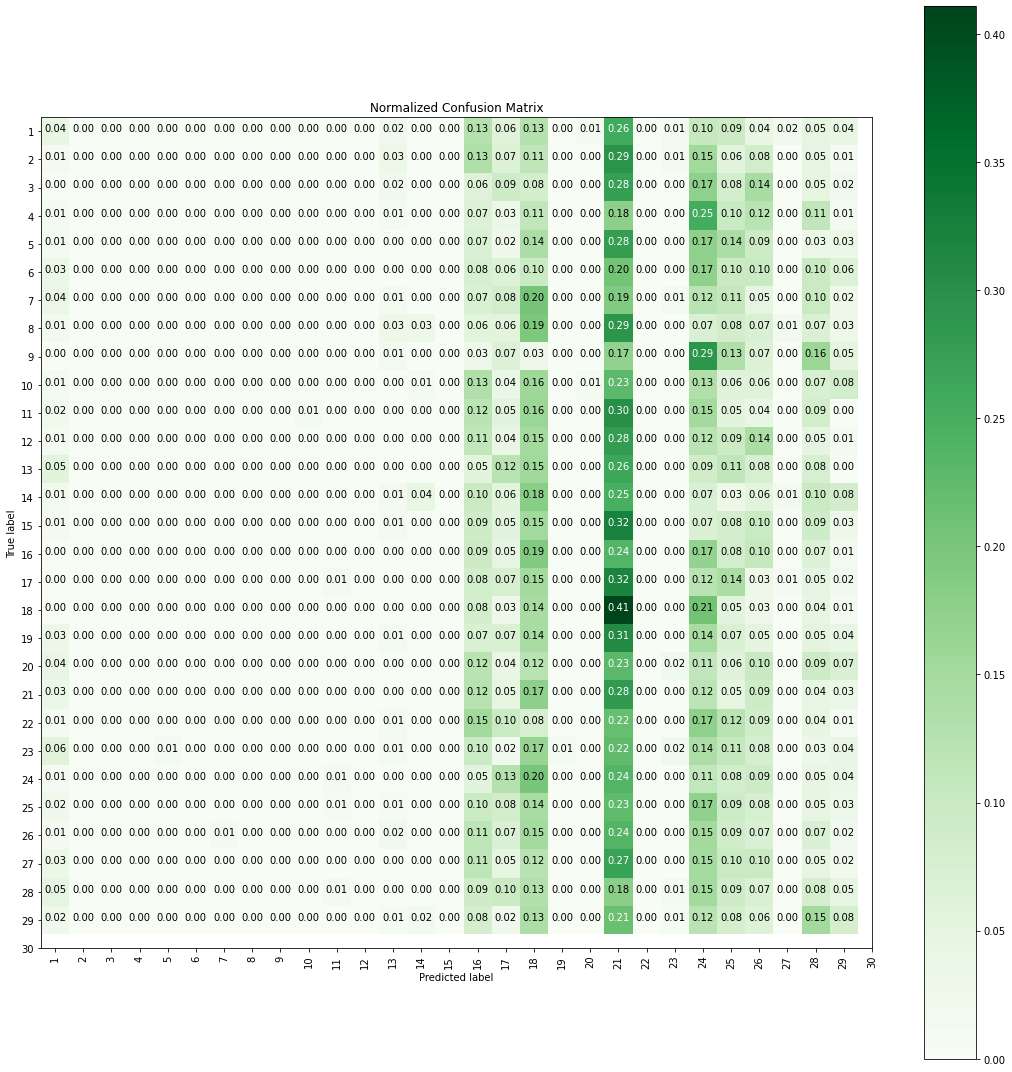


 F1 Score:0.024578374512490765


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.05829628494046707
epsilon: 1.0
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:19:10.981726

Predicting test data
==> testing time:- 0:00:00.542078

==> Accuracy:- 0.06155950752393981


 ********Confusion Matrix********

 [[21  0  2  0  0  0  1  0  0  2  0  0  5  1  0  9  4 10  1  2 14  0  1  9
   7  7  1 13  7]
 [ 1  2  1  0  0  0  0  0  0  0  1  0  2  2  2  8  8 13  0  0 22  0  1 12
   9 10  1  9  2]
 [ 4  0  3  0  0  0  1  1  0  0  1  0  1  0  0  7  5  7  0  0 16  0  1 14
  14 10  0  5  8]
 [ 4  0  2  1  0  1  0  0  0  1  3  0  1  0  1  6  4  7  0  0 14  0  0 17
  14  5  1  8  1

/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_95765/1524874641.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


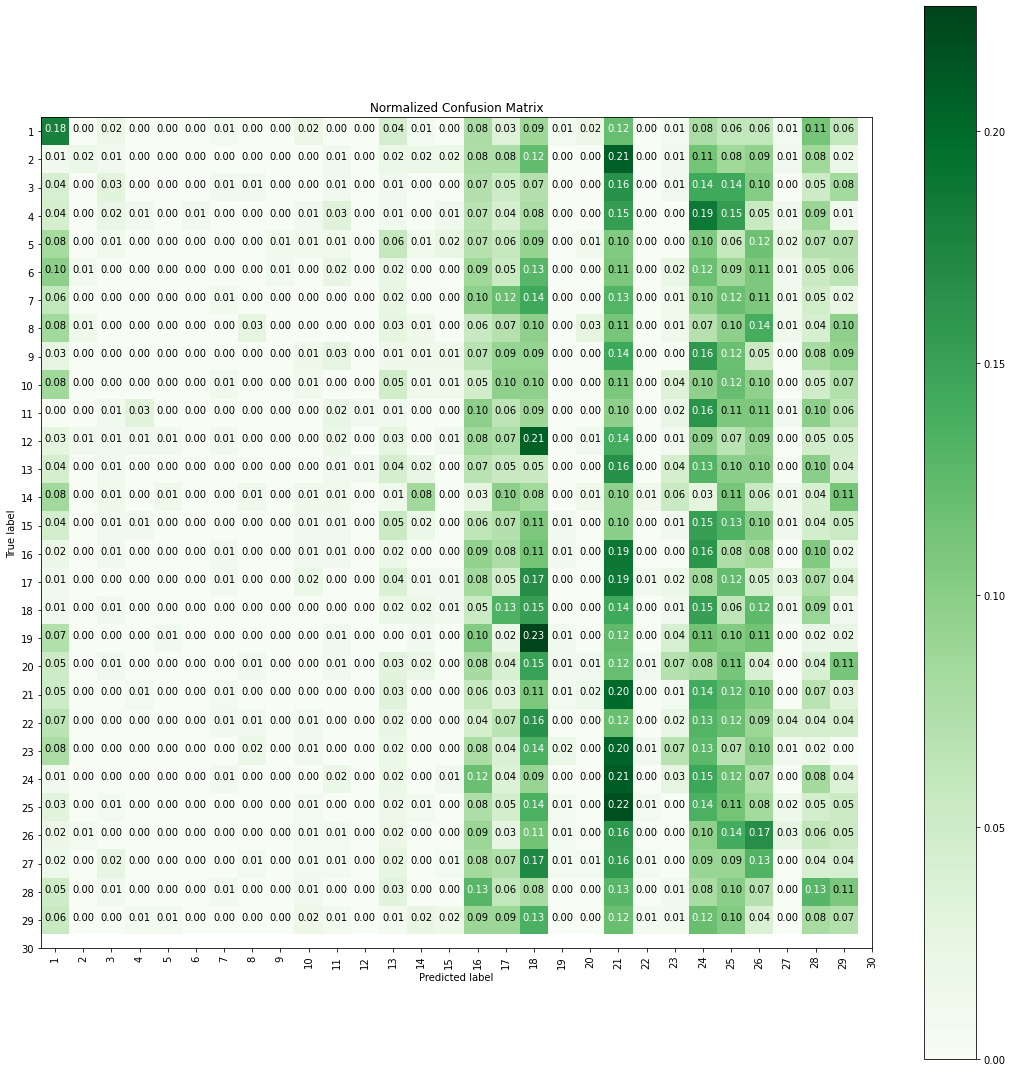


 F1 Score:0.04610527000067421


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.059140590843794895
epsilon: 1.1
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits


KeyboardInterrupt: 

In [49]:
f1_array_random_uid = []
acc_array_random_uid = []

params = {'n_estimators': np.arange(150,201,10), 'max_depth':np.arange(6,15,2)}

for epsilon in epsilons:
  print("epsilon: "+ str(epsilon))
  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'user_Id')

  for col in X_train:
    # default sensitivity = 1.0
    # print("------epsilon--------")
    X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))

  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=10, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels_uid)

  f1_array_random_uid.append(f1)
  acc_array_random_uid.append(rfc_grid_results['accuracy'])

  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons, f1_array_random_uid, label='Random Forest Classifier in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('f1_score')
plt.legend(loc='best')
plt.show()



In [ ]:
params = {'n_estimators': np.arange(150,201,10), 'max_depth':np.arange(6,15,2)}

X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'user_Id')

rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, cv=10, verbose=1, n_jobs=-1)
rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels_uid)

f1_array_random_uid.append(f1)
acc_array_random_uid.append(rfc_grid_results['accuracy'])

# observe the attributes of the model 
print_grid_search_attributes(rfc_grid_results['model'])

print(f1_array_random_uid)


epsilon: 1.0
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:12:58.125245

Predicting test data
==> testing time:- 0:00:00.960015

==> Accuracy:- 0.5992779783393501


 ********Confusion Matrix********

 [[416  53  62   0   8   2]
 [271 143  55   5  15   3]
 [154  34 237   0   3   0]
 [  1   0   0  75 353  77]
 [  0   0   0  53 447  33]
 [  0   0   0  15  24 508]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_34059/1524874641.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


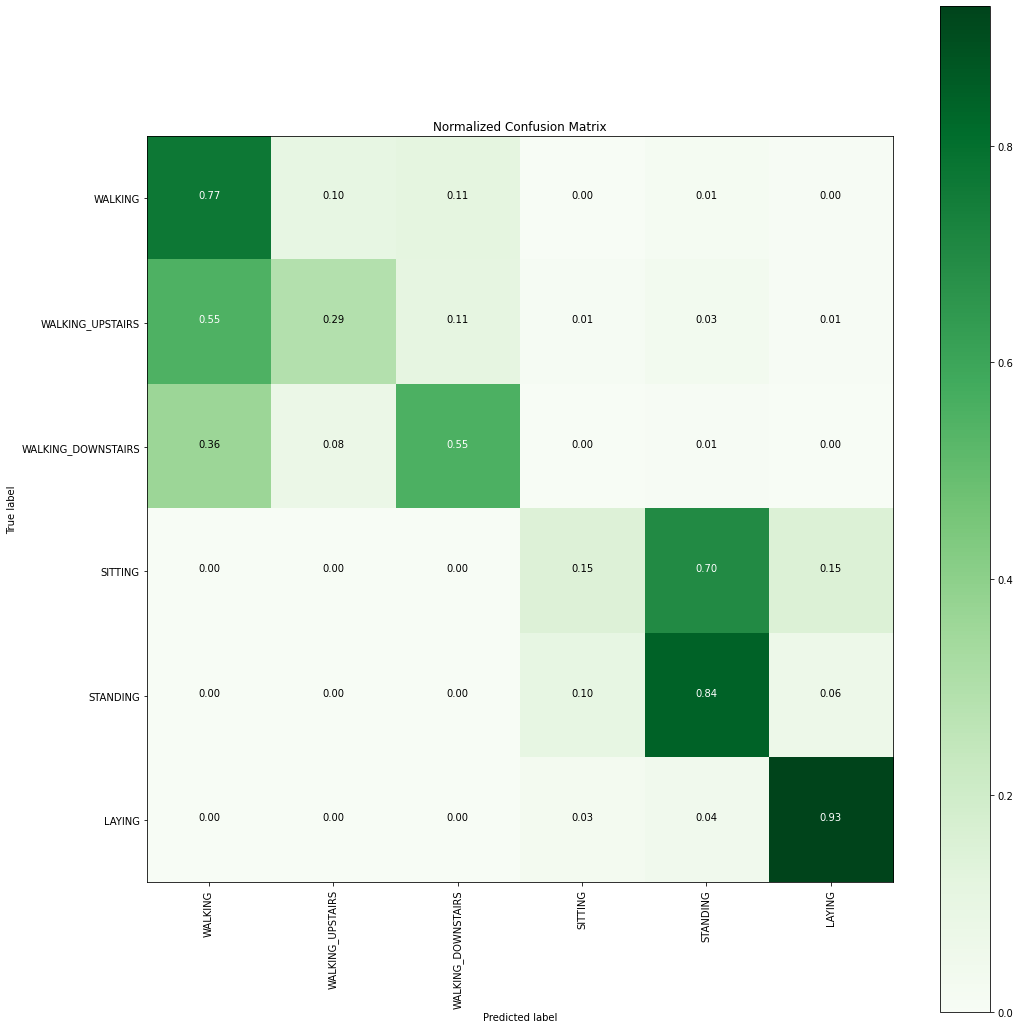


 F1 Score:0.5580009044445633


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6113807111376006
epsilon: 1.1
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:15:38.771232

Predicting test data
==> testing time:- 0:00:00.499638

==> Accuracy:- 0.6160157531998687


 ********Confusion Matrix********

 [[440  39  59   0   2   1]
 [284 132  50   2  21   3]
 [138  27 260   0   1   2]
 [  0   0   0  64 355  87]
 [  0   1   0  33 457  42]
 [  0   0   0   6  17 524]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_34059/1524874641.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


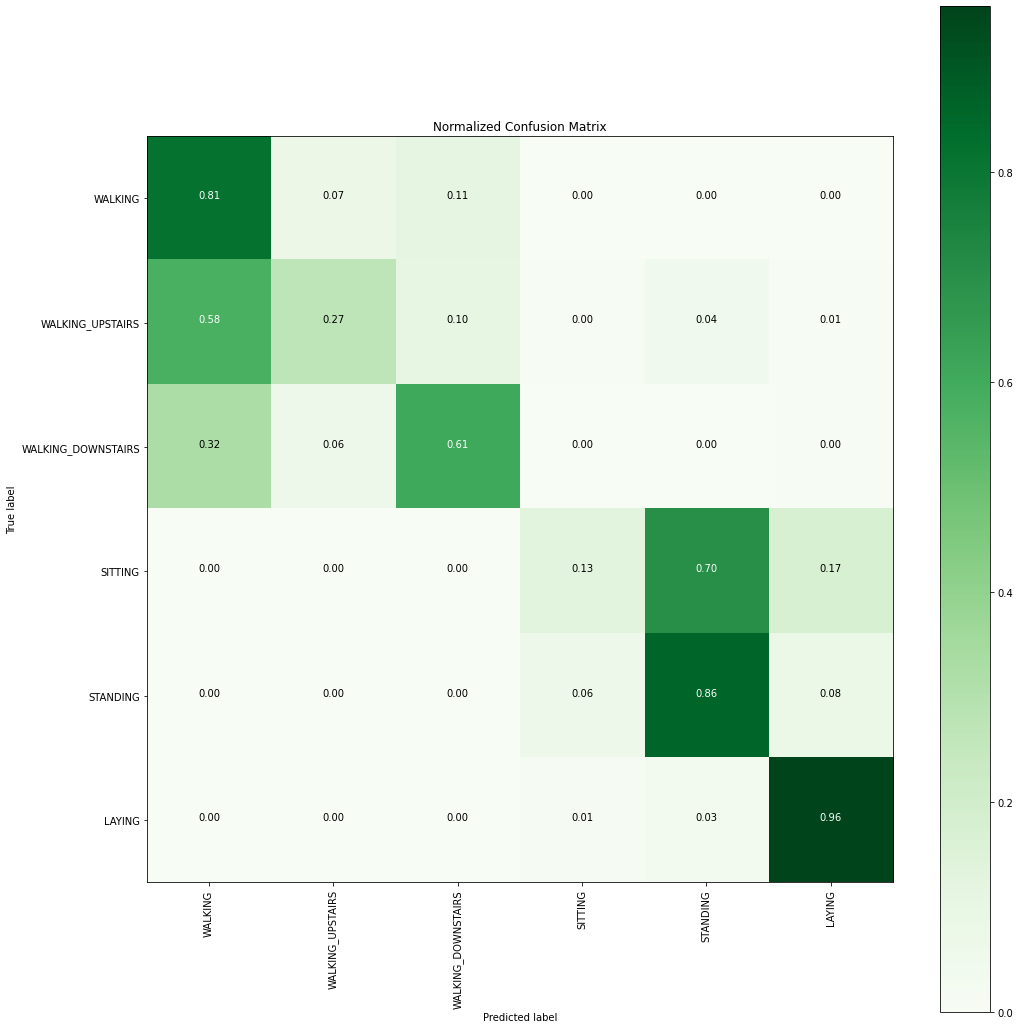


 F1 Score:0.5666102872616224


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.634170104197709
epsilon: 2.0
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:14:44.286619

Predicting test data
==> testing time:- 0:00:00.348323

==> Accuracy:- 0.7630456186412865


 ********Confusion Matrix********

 [[456  46  39   0   0   0]
 [123 327  42   0   0   0]
 [ 76  53 299   0   0   0]
 [  0   0   0 225 252  29]
 [  0   0   0  59 474   0]
 [  0   0   0   3   0 544]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_34059/1524874641.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


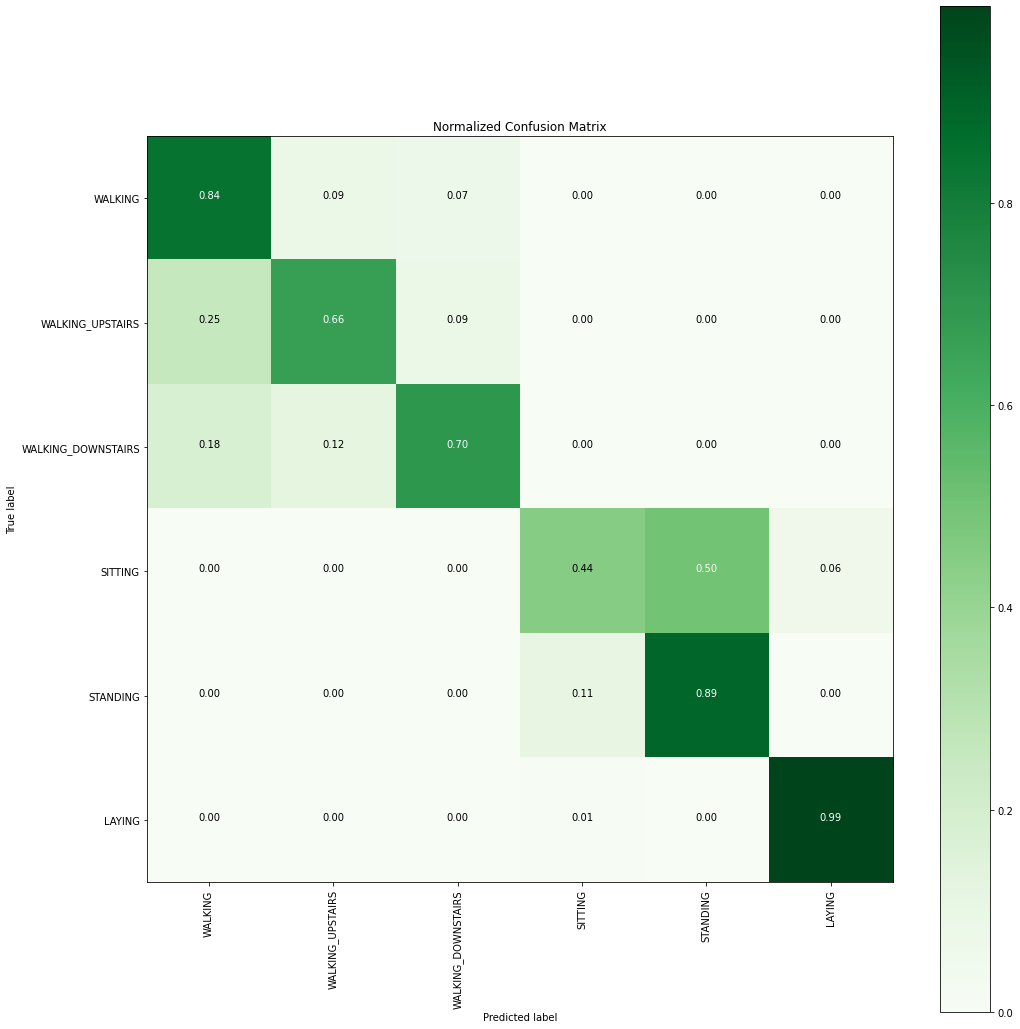


 F1 Score:0.7511552606625277


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7723868228848074
epsilon: 2.1
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:13:50.935497

Predicting test data
==> testing time:- 0:00:00.289968

==> Accuracy:- 0.7755169018706924


 ********Confusion Matrix********

 [[474  33  33   0   1   0]
 [133 318  38   1   2   0]
 [ 74  50 303   0   1   0]
 [  0   0   0 237 248  21]
 [  0   0   0  48 484   1]
 [  0   0   0   0   0 547]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_34059/1524874641.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


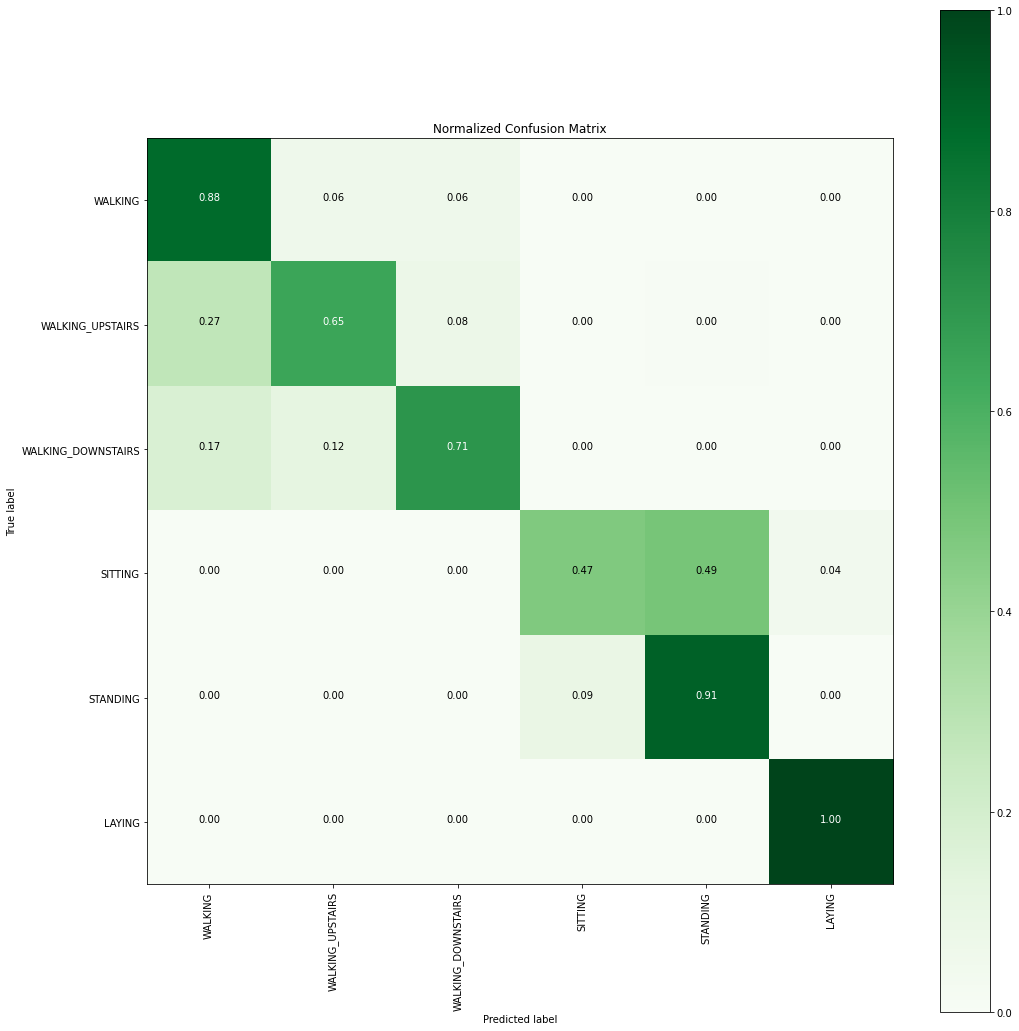


 F1 Score:0.764195229843747


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7761105970063418
epsilon: 2.2
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:10:28.732422

Predicting test data
==> testing time:- 0:00:00.263000

==> Accuracy:- 0.7682966852641943


 ********Confusion Matrix********

 [[452  52  36   0   1   0]
 [117 320  52   1   2   0]
 [ 79  47 302   0   0   0]
 [  0   0   0 243 233  30]
 [  0   0   0  54 478   1]
 [  0   0   0   1   0 546]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_34059/1524874641.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


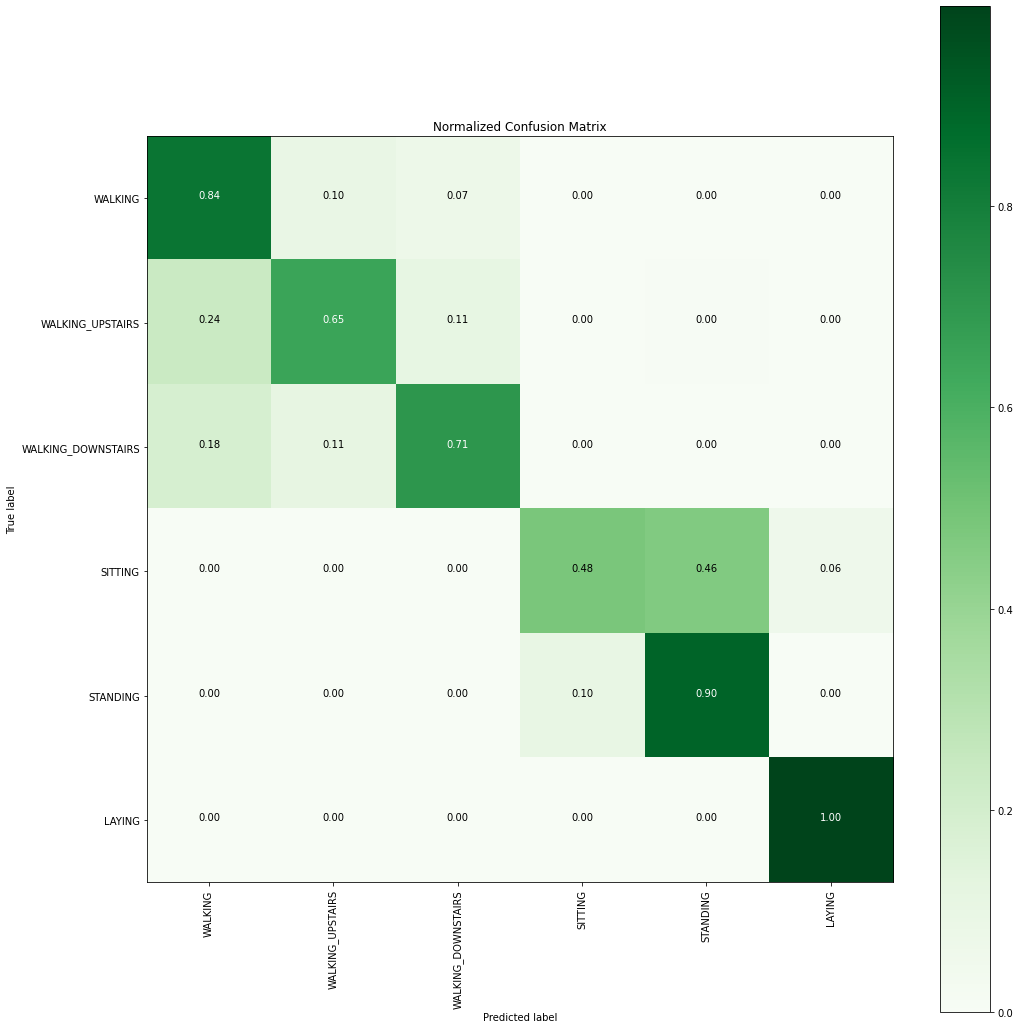


 F1 Score:0.7571851124458018


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7898505262167291
epsilon: 2.5
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:12:31.094365

Predicting test data
==> testing time:- 0:00:00.299639

==> Accuracy:- 0.8037413849688217


 ********Confusion Matrix********

 [[479  36  25   0   1   0]
 [ 97 349  45   1   0   0]
 [ 64  51 313   0   0   0]
 [  0   0   0 269 214  23]
 [  0   0   0  39 494   0]
 [  0   0   0   2   0 545]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_34059/1524874641.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


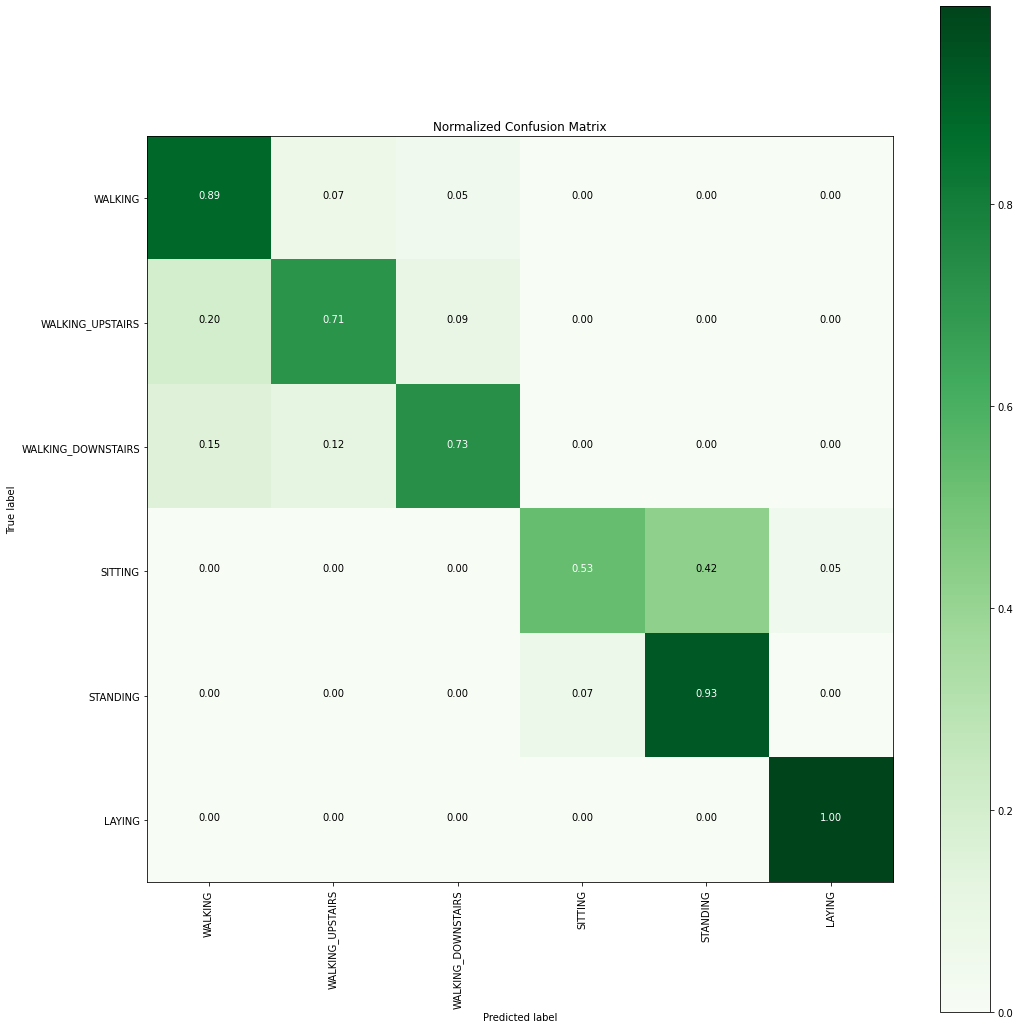


 F1 Score:0.7944658419144702


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8162026653282515


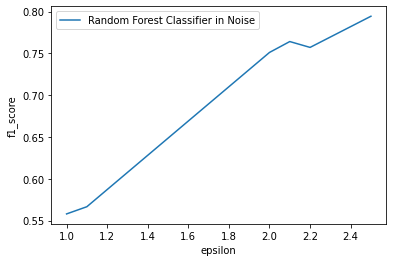

In [ ]:
f1_array_random_act = []
acc_array_random_act = []

params = {'n_estimators': np.arange(150,181,10), 'max_depth':np.arange(6,15,2)}

for epsilon in epsilons:
  print("epsilon: "+ str(epsilon))
  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'activity_Id')

  for col in X_train:
    # default sensitivity = 1.0
    # print("------epsilon--------")
    X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))

  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=10, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels_act)

  f1_array_random_act.append(f1)
  acc_array_random_act.append(rfc_grid_results['accuracy'])

  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons, f1_array_random_act, label='Random Forest Classifier in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('f1_score')
plt.legend(loc='best')
plt.show()


In [ ]:
params = {'n_estimators': np.arange(150,201,10), 'max_depth':np.arange(6,15,2)}

X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'activity_Id')

rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, cv=10, verbose=1, n_jobs=-1)
rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels_act)

f1_array_random_act.append(f1)
acc_array_random_act.append(rfc_grid_results['accuracy'])

# observe the attributes of the model 
print_grid_search_attributes(rfc_grid_results['model'])


print(f1_array_random_act)


In [ ]:
# epsilons = [0.005, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 2.5, no]
# epsilons = [ 0.01, 0.05, 0.1, 0.5, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 'no']
# epsilons = [1.0, 1.1,  1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.5]
print(f1_array_random_act)
print(f1_array_random_uid)
print(acc_array_random_act)
print(acc_array_random_uid)

[0.5580009044445633, 0.5666102872616224, 0.7511552606625277, 0.764195229843747, 0.7571851124458018, 0.7944658419144702]
[0.03452664158446594, 0.04016900440977814, 0.10521763174179014, 0.11017137429077249, 0.13619020944692778, 0.1723408589096754]
[0.5992779783393501, 0.6160157531998687, 0.7630456186412865, 0.7755169018706924, 0.7682966852641943, 0.8037413849688217]
[0.05251066622907778, 0.05776173285198556, 0.11814899901542501, 0.12372825730226453, 0.1444043321299639, 0.18214637348211354]
